<a href="https://colab.research.google.com/github/SeiichiroFukushima/keras/blob/master/LSTM_try04-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

data_file='/content/drive/MyDrive/Colab Notebooks/total_0621_MAG_mod.csv'
#csvファイルの読み込み
data=pd.read_csv(data_file).values
#時刻データ{Unnamed: 0.2, Unnamed: 0.1, Unnamed: 0, No., ｶﾒﾗ時間}（一番左側から５つ）は使わないので除去する
data=data[:,5:]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
#データを入力(X)４つ、出力(Y)２つに分ける
#CurrFB, VoltFBのうちCurrFBだけ除外してみる。
input_data=data[:,2:13]
output_data=data[:,0:1]

print( 'input_data=[', input_data.shape[0], ',', input_data.shape[1], ']')
print( 'output_data=[', output_data.shape[0], ',', output_data.shape[1],']')


input_data=[ 803 , 11 ]
output_data=[ 803 , 1 ]


In [101]:
output_data

array([[ 54],
       [ 75],
       [181],
       [ 67],
       [ 79],
       [ 77],
       [ 62],
       [104],
       [ 85],
       [ 64],
       [ 59],
       [132],
       [ 93],
       [ 88],
       [ 39],
       [ 46],
       [ 88],
       [122],
       [ 57],
       [ 58],
       [109],
       [ 94],
       [ 68],
       [ 82],
       [ 70],
       [ 84],
       [ 55],
       [ 47],
       [ 85],
       [ 49],
       [ 91],
       [ 98],
       [ 80],
       [ 62],
       [ 60],
       [ 57],
       [ 88],
       [ 45],
       [ 34],
       [ 61],
       [179],
       [141],
       [ 68],
       [ 66],
       [ 63],
       [118],
       [ 79],
       [133],
       [ 63],
       [ 51],
       [ 54],
       [ 45],
       [118],
       [ 64],
       [ 52],
       [ 38],
       [ 79],
       [187],
       [ 92],
       [ 53],
       [ 45],
       [ 49],
       [ 70],
       [ 62],
       [103],
       [105],
       [111],
       [ 92],
       [ 78],
       [138],
       [154],
      

In [102]:
input_data

array([[58327,  1355,  3645, ...,  2844,     0,   324],
       [51949,  1865,  3135, ...,  4062,     0,   491],
       [52110,  1849,  3151, ...,  3373,   291,   460],
       ...,
       [55063,  1685,  3315, ...,  4182,   322,   417],
       [54089,  1794,  3206, ...,  4473,   335,   568],
       [57355,  1520,  3480, ...,  3306,   677,   384]])

In [103]:
Xdata=[]
Ydata=[]
#LSTM用にデータ加工
#入力データの時間：5x200ms １秒間の傾向
look_back=5
number = int( data.shape[0] / look_back ) - 1
for i in range(number):
    Xtimedata=[]
    data_head = i * look_back
    for j in range(input_data.shape[1]):
        Xtimedata.append(input_data[data_head:data_head+look_back,j])
    Xtimedata=np.array(Xtimedata)
    Xtimedata=Xtimedata.transpose()
    Xdata.append(Xtimedata)
    Ytimedata=[]
    sum=0
    for j in range(look_back):
        sum += output_data[data_head+j,0]
    Ytimedata.append(sum/look_back)
    Ydata.append(Ytimedata)

In [104]:
Xdata=np.array(Xdata)
Ydata=np.array(Ydata)

print(Xdata.shape)
#print(Xdata)
print(Ydata.shape)
#print(Ydata)


(159, 5, 11)
(159, 1)


In [105]:
#ライブラリインポート
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [106]:
train_mean = Xdata.mean()
train_std = Xdata.std()

test_mean = Ydata.mean()
test_std = Ydata.std()

Xdata = (Xdata - train_mean) / train_std
Ydata = (Ydata - test_mean) / test_std

In [107]:
#学習用の情報指定
Xdim=Xdata.shape[2]
Ydim=Ydata.shape[1]
validation_split_rate=0.2
print('Xdim=',Xdim,', Ydim=',Ydim,', validation_split_rate=',validation_split_rate)

Xdim= 11 , Ydim= 1 , validation_split_rate= 0.2


In [108]:
#モデル構築
#LSTMレイヤを多層化して複雑な表現ができるようにする。
#LSTM(34,...の34はユニット数でより複雑で長期的な傾向を理解するためにはユニット数をある程度の大きさにする。
model = Sequential()
model.add(LSTM(34, return_sequences=True, input_shape=(look_back,Xdim)))
#model.add(LSTM(34, return_sequences=True))
#model.add(LSTM(34, return_sequences=True))
#model.add(LSTM(34, return_sequences=True))
model.add(LSTM(34))
model.add(Dense(Ydim))
model.compile(loss="mean_squared_error", optimizer=Adam(lr=0.001))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 5, 34)             6256      
                                                                 
 lstm_17 (LSTM)              (None, 34)                9384      
                                                                 
 dense_6 (Dense)             (None, 1)                 35        
                                                                 
Total params: 15,675
Trainable params: 15,675
Non-trainable params: 0
_________________________________________________________________


In [109]:
#学習開始
history=model.fit(Xdata,Ydata,batch_size=16,epochs=500,validation_split=validation_split_rate)

Epoch 1/500
8/8 [==============================] - 5s 93ms/step - loss: 1.1854 - val_loss: 0.3997
Epoch 2/500
8/8 [==============================] - 0s 10ms/step - loss: 1.1444 - val_loss: 0.4102
Epoch 3/500
8/8 [==============================] - 0s 9ms/step - loss: 1.1358 - val_loss: 0.4068
Epoch 4/500
8/8 [==============================] - 0s 8ms/step - loss: 1.1232 - val_loss: 0.4003
Epoch 5/500
8/8 [==============================] - 0s 9ms/step - loss: 1.1101 - val_loss: 0.3925
Epoch 6/500
8/8 [==============================] - 0s 8ms/step - loss: 1.0920 - val_loss: 0.3863
Epoch 7/500
8/8 [==============================] - 0s 8ms/step - loss: 1.0651 - val_loss: 0.3825
Epoch 8/500
8/8 [==============================] - 0s 11ms/step - loss: 1.0272 - val_loss: 0.3891
Epoch 9/500
8/8 [==============================] - 0s 9ms/step - loss: 0.9722 - val_loss: 0.3645
Epoch 10/500
8/8 [==============================] - 0s 9ms/step - loss: 0.9092 - val_loss: 0.3387
Epoch 11/500
8/8 [========

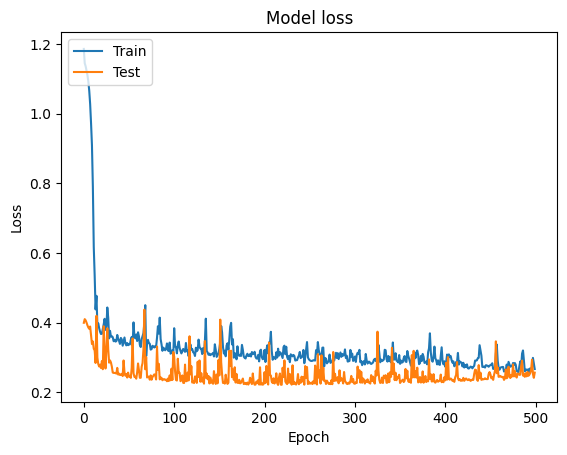

In [110]:
#学習履歴のグラフ化
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [111]:
#学習データから学習時にテストデータとして用いた部分を取り出す
Xdata_validation=Xdata[-int(len(Xdata)*(validation_split_rate)):]
Ydata_validation=Ydata[-int(len(Ydata)*(validation_split_rate)):]

1/1 [==============================] - 1s 556ms/step


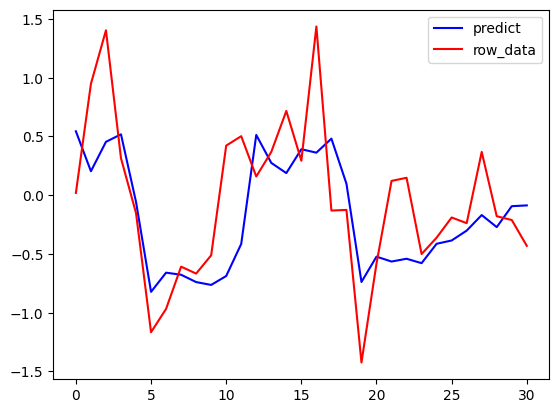

In [112]:
#テスト
Predictdata = model.predict(Xdata_validation)
#テスト結果のグラフ化
plt.plot(range(0, len(Predictdata)),Predictdata[:,0], color="b", label="predict")
plt.plot(range(0, len(Ydata_validation)),Ydata_validation[:,0], color="r", label="row_data")
plt.legend()
plt.show()

In [113]:
import pandas as pd
predict_df = pd.DataFrame(Predictdata, columns=["predict"])
validation_df = pd.DataFrame(Ydata_validation, columns=["row_data"])
predict_df.to_csv("/content/drive/MyDrive/Colab Notebooks/RENEW_predict_data0623-1.csv", index=False)
validation_df.to_csv("/content/drive/MyDrive/Colab Notebooks/RENEW_validation_data0623-1.csv", index=False)
